# Basic GIS and mapping in Python

- Jacob Eisenstein
- For GaTech CS 4464/6465, Spring 2016

In [31]:
from mpl_toolkits.basemap import Basemap # displaying and plotting on maps
import matplotlib.pyplot as plt
%pylab inline
from geopy.geocoders import Nominatim, GoogleV3 # for geocoding and reverse geocoding
from geopy.distance import great_circle

Populating the interactive namespace from numpy and matplotlib


In [32]:
nom_geo = Nominatim()
goog_geo = GoogleV3()

## Geocoding ##

In geocoding, we convert location names to latitude-longitude coordinates.

In [33]:
flint_loc = nom_geo.geocode('Flint, MI')
print flint_loc
print goog_geo.geocode('Flint, MI')

(u'Flint, Genesee County, Michigan, United States of America', (43.0171773, -83.7236023))
(u'Flint, MI, USA', (43.0125274, -83.6874562))


Flint was buying water from Detroit. How far apart are they?

In [34]:
detroit_loc = nom_geo.geocode('Detroit,MI')
print detroit_loc

(u'Detroit, Wayne County, Michigan, United States of America', (42.3486635, -83.0567374))


In [35]:
print great_circle(flint_loc[1],detroit_loc[1])

92.2050822312 km


People used to get ice from Fresh Pond in Cambridge, MA. Perhaps the Flintians would prefer to get their water from there.

In [37]:
fresh_pond_loc = nom_geo.geocode('Fresh Pond, MA')
print fresh_pond_loc
print great_circle(flint_loc[1],fresh_pond_loc[1])

(u'Fresh Pond, Beech Path, Strawberry Hill, Cambridge, Middlesex County, Massachusetts, 02140, United States of America', (42.384173, -71.1489033160316))
1029.30858035 km


## Mapping ##

Now let's use Basemap to show the location on a map.

To do this, we'll need to decide on a map projection. XKCD provides [a helpful guide](https://xkcd.com/977/).

In [49]:
def mapAroundPoint(point,width=1e6,height=1e6,resolution='c'):
    m = Basemap(width=width,height=height,
                projection='stere', #there are several projection types
                resolution=resolution, #higher resolutions are slow
                lat_0=point[0],lon_0=point[1])
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates(color='gray',linewidth=0.5)
    m.drawcounties(color='gray',linewidth=0.2)
    m.drawmapboundary()
    m.drawrivers(color='b',linewidth=0.2)
    m.drawlsmask()
    m.scatter(point[1],point[0],100,latlon=True,color='r')
#    text(point[1],point[0],'Flint',latlon=True)

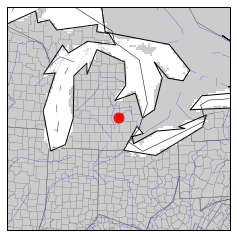

In [50]:
mapAroundPoint(flint_loc[1])

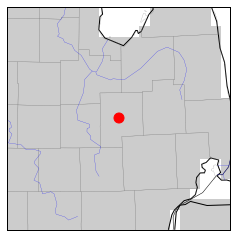

In [51]:
mapAroundPoint(flint_loc[1],width=2e5,height=2e5,resolution='i')

## Reverse geo-coding ##

Reverse geo-coding is converting latitude-longitude pairs into location names. This is useful if you get GPS-tagged data like tweets.

In [38]:
print flint_loc[1]

(43.0171773, -83.7236023)


In [39]:
print nom_geo.reverse(flint_loc[1])

(u'2401, Norbert Street, City of Flint, Genesee County, Michigan, 48504, United States of America', (43.017304, -83.723644))


In [41]:
for answer in goog_geo.reverse(flint_loc[1]):
    print answer

(u'423 Weller St, Flint, MI 48504, USA', (43.017157, -83.72379699999999))
(u'Flint, MI, USA', (43.0125274, -83.6874562))
(u'Flint, MI 48504, USA', (43.0528038, -83.75178509999999))
(u'Flint, MI, USA', (43.0777289, -83.67739279999999))
(u'Genesee County, MI, USA', (43.0777289, -83.67739279999999))
(u'Michigan, USA', (44.3148443, -85.60236429999999))
(u'United States', (37.09024, -95.712891))


# Mapping the Flint data #

Let's try to recreate this visualization.

<img align='left' width='700' src='https://espnfivethirtyeight.files.wordpress.com/2016/01/ambj-flint-lead-chart-21.png?w=1024&h=730'/>

To do this properly, we'd need shapefiles for the wards. We don't have this, so let's just use zipcodes instead.

In [42]:
import pandas as pd

In [43]:
df = pd.read_csv('flint-data-simple.csv',delimiter='\t')

In [44]:
df.head(3)

,SampleID,Zip Code,Ward,Pb Bottle 1 (ppb) - First Draw,Pb Bottle 2 (ppb) - 45 secs flushing,Pb Bottle 3 (ppb) - 2 mins flushing
0,1,48504,6,0.344,0.226,0.145
1,2,48507,9,8.133,10.770,2.761
2,4,48504,1,1.111,0.110,0.123


In [45]:
zipcodes = df['Zip Code'].unique()
print zipcodes

[48504 48507 48505 48503 48506 48529 48532 48502]


Apparently Nominatim doesn't handle this, so let's focus on GoogleAPI

In [46]:
for zipcode in zipcodes:
    print zipcode, goog_geo.geocode('Flint, MI '+str(zipcode))[1], nom_geo.geocode('Flint, MI '+str(zipcode))[1]

48504 (43.0528038, -83.75178509999999) (43.0171773, -83.7236023)
48507 (42.9753551, -83.75178509999999) (43.0171773, -83.7236023)
48505 (43.0686471, -83.6880257) (43.0171773, -83.7236023)
48503 (43.0145534, -83.6720756) (43.0171773, -83.7236023)
48506 (43.0125274, -83.6874562) (43.0171773, -83.7236023)
48529 (42.9752297, -83.66144000000001) (43.0171773, -83.7236023)
48532 (43.0164056, -83.7942551) (43.0171773, -83.7236023)
48502 (43.0142978, -83.6893547) (43.0171773, -83.7236023)


Now we'll add a column indicating whether the lead was above the action level of 5ppb.

In [47]:
df['heavyPB'] = 1.*(df['Pb Bottle 1 (ppb) - First Draw'] > 5)

In [48]:
df_zips = df.groupby('Zip Code').agg(np.mean)
print df_zips['heavyPB']

Zip Code
48502    0.000000
48503    0.521739
48504    0.327273
48505    0.312500
48506    0.340909
48507    0.490196
48529    0.000000
48532    0.500000
Name: heavyPB, dtype: float64


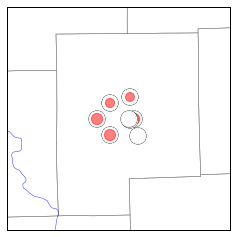

In [25]:
m = Basemap(width=6e4,height=6e4,
                projection='stere', #there are several projection types
                resolution='f', #higher resolutions are slow
                lat_0=flint_loc[1][0],lon_0=flint_loc[1][1])
#m.bluemarble()
#m.drawcoastlines()
#m.drawstates(color='gray',linewidth=0.5)
m.drawcounties(color='gray',linewidth=0.5)
m.drawmapboundary()
m.drawrivers(color='b',linewidth=0.4)
#m.drawlsmask()
for zipcode in zipcodes:
    size = 256 * df_zips.loc[zipcode]['heavyPB']
    zip_center = goog_geo.geocode('Flint, MI '+str(zipcode))[1]
    m.scatter(zip_center[1],zip_center[0],256,color='k',latlon=True)
    m.scatter(zip_center[1],zip_center[0],240,color='w',latlon=True)
    m.scatter(zip_center[1],zip_center[0],size,color='r',latlon=True,alpha=.5)

Best I could do! This would look better if we had street shapes. Could get this from [openstreetmap](http://www.openstreetmap.org/node/27023456), for example.